In [114]:
import pandas as pd
from datetime import datetime

In [2]:
date_parser = pd.to_datetime
red_drum_tag = pd.read_csv("../../../red_drum_weekly_centroid_satellite_class.csv",
                           parse_dates=["week_utc"],
                           skiprows=4)

In [128]:
red_drum_monthly = red_drum_tag.groupby(
    [pd.PeriodIndex(red_drum_tag.week_utc, freq="M"),
     red_drum_tag.tag_id])[["longitude","latitude"]].mean().reset_index()

In [146]:
red_drum_tag.groupby(
    [pd.PeriodIndex(red_drum_tag.week_utc, freq="M"),
     red_drum_tag.tag_id])["n_days_detected"].mean().reset_index().to_csv("mean-days.csv", index=False)

In [63]:
date_range = (min(red_drum_tag.week_utc),
              max(red_drum_tag.week_utc))
date_list = red_drum_tag.week_utc.unique()
lat_range = (min(red_drum_tag.latitude)-1,
             max(red_drum_tag.latitude)+1)
lon_range = (min(red_drum_tag.longitude)-1,
             max(red_drum_tag.longitude+1))

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

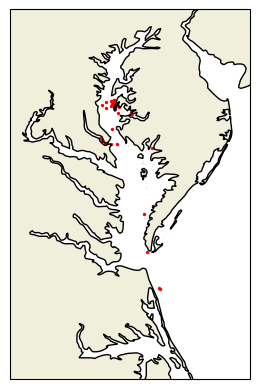

In [64]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
#ax.plot(lon_range,lat_range)
ax.scatter(red_drum_tag.longitude, red_drum_tag.latitude, s=2, color="red")

ax.set_extent([min(lon_range), max(lon_range),
               min(lat_range), max(lat_range)])

In [7]:
import earthaccess
import xarray as xr

# Login
auth = earthaccess.login()

/home/tct/fish-pace/2026-proj-fishing-reddrum/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
month_str_list = ["2024-06-01","2024-07-01","2024-08-01","2024-09-01","2024-10-01","2024-11-01","2024-12-01","2025-01-01"]

In [40]:
months = [pd.to_datetime(month_str) for month_str in month_str_list]

In [43]:
results = earthaccess.search_data(
    short_name="MODIS_AQUA_L3_SST_THERMAL_MONTHLY_4KM_DAYTIME_V2019.0",
    temporal=tuple(date_range),
)

results_non_nrt = [r for r in results if "NRT" not in r.data_links()[0]]

In [46]:
fileset = earthaccess.open(results_non_nrt)

ds = xr.open_mfdataset(fileset, concat_dim="time", combine="nested")


    #chesapeake_weekly_datasets.append(ds_chesapeake.mean(dim="time")
    #break

QUEUEING TASKS | : 100%|███████████████████████████████████████| 8/8 [00:00<00:00, 1177.22it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████| 8/8 [00:03<00:00,  2.27it/s]
COLLECTING RESULTS | : 100%|██████████████████████████████████| 8/8 [00:00<00:00, 62601.55it/s]


In [173]:
fileset[0].info()['name'].split('.')[6][:8]

'20240601'

In [174]:
datasets = []
for f in fileset:
    time = datetime.strptime(f.info()['name'].split('.')[6][:8], "%Y%m%d")
    dataset = xr.open_dataset(f)
    dataset["time"] = time
    datasets.append(dataset)

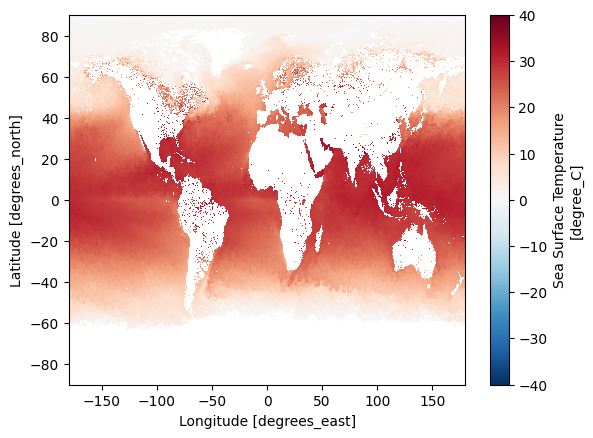

In [190]:
datasets[0]["sst"].plot(x="lon",y="lat")

In [175]:
ds = xr.concat(datasets, dim="time")

/home/tct/fish-pace/2026-proj-fishing-reddrum/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:673: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [176]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 8, lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * time      (time) datetime64[ns] 64B 2024-06-01 2024-07-01 ... 2025-01-01
  * lat       (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon       (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (time, lat, lon) float32 1GB -0.19 -0.19 -0.19 ... nan nan nan
    qual_sst  (time, lat, lon) float32 1GB 1.0 1.0 1.0 1.0 ... nan nan nan nan
    palette   (time, rgb, eightbitcolor) uint8 6kB 91 10 118 99 9 ... 204 0 0 0
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20240601_20240630.L3m.MO.SST...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Optics >...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        23160804
    data_minimum:                     -1.7750001
    data_maximum:                     40.0

In [65]:
ds_chesapeake = ds.sel(lat=slice(lat_range[1], lat_range[0]),
                       lon=slice(lon_range[0], lon_range[1]))

In [68]:
ds_chesapeake

<xarray.Dataset> Size: 408kB
Dimensions:   (time: 8, lat: 98, lon: 64, rgb: 3, eightbitcolor: 256)
Coordinates:
  * time      (time) datetime64[ns] 64B 2024-06-01 2024-07-01 ... 2025-01-01
  * lat       (lat) float32 392B 39.77 39.73 39.69 39.65 ... 35.81 35.77 35.73
  * lon       (lon) float32 256B -77.48 -77.44 -77.4 ... -74.94 -74.9 -74.85
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (time, lat, lon) float32 201kB nan nan nan ... 17.24 17.86 19.06
    qual_sst  (time, lat, lon) float32 201kB nan nan nan nan ... 0.0 0.0 0.0 0.0
    palette   (time, rgb, eightbitcolor) uint8 6kB 91 10 118 99 9 ... 204 0 0 0
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20240601_20240630.L3m.MO.SST...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Optics >...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        23160804
    data_minimum:                     -1.7750001
    data_maximum:                     40.0

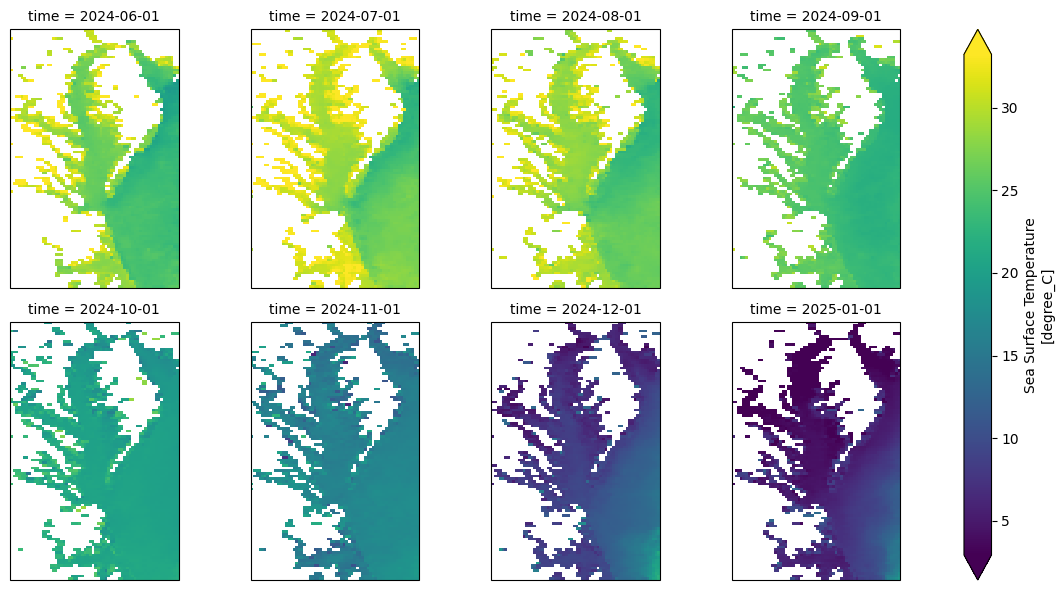

In [91]:
ds_chesapeake['sst'].plot(
    col="time",
    col_wrap=4,
    robust=True,
    subplot_kws={"projection": ccrs.PlateCarree()},
    transform=ccrs.PlateCarree()
)

In [151]:
help(datetime.strptime)

Help on built-in function strptime:

strptime(...) class method of datetime.datetime
    string, format -> new datetime parsed from a string (like time.strptime()).



In [153]:
month_str

'2025-01-01'

In [154]:
datetime.strptime(month_str, "%Y-%m-%d")

datetime.datetime(2025, 1, 1, 0, 0)

In [157]:
sst_plot.mean()

<xarray.DataArray 'sst' ()> Size: 4B
array(6.0831304, dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2025-01-01
Attributes:
    long_name:      Sea Surface Temperature
    units:          degree_C
    standard_name:  sea_surface_temperature
    valid_min:      -1000
    valid_max:      10000
    display_scale:  linear
    display_min:    -2.0
    display_max:    45.0

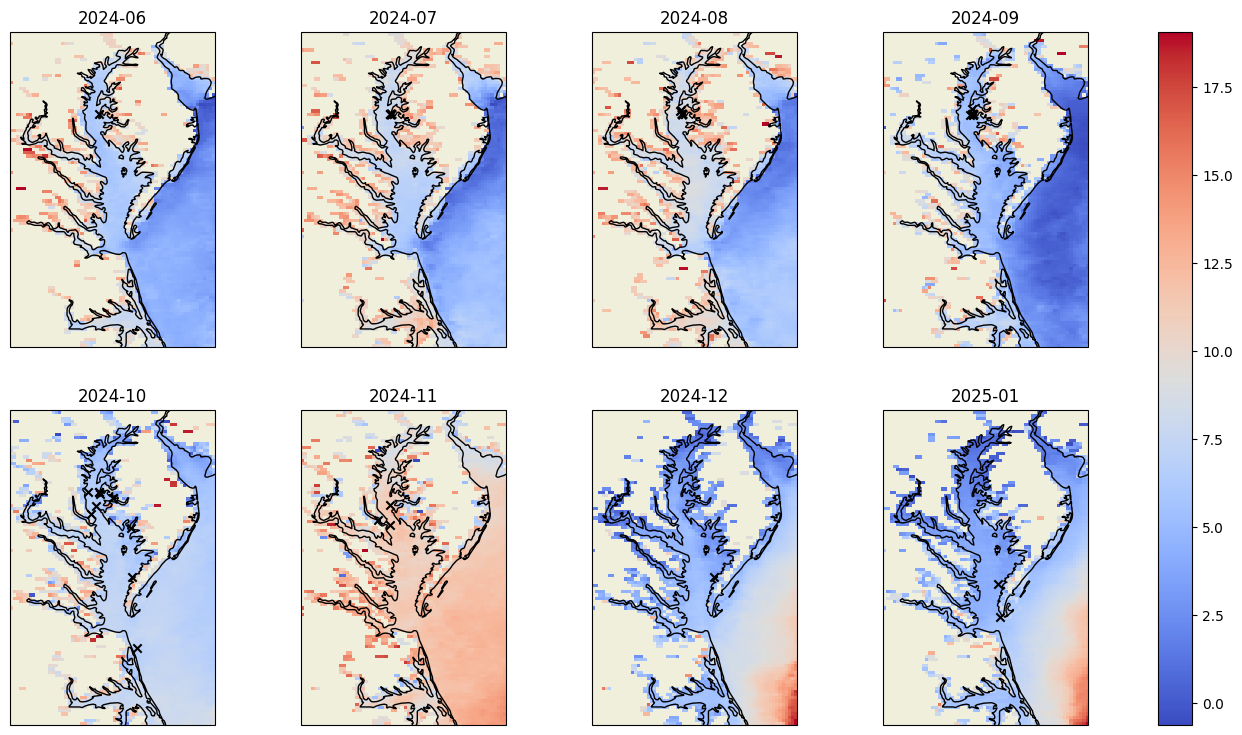

In [155]:
fig, axs = plt.subplots(
    nrows=2, ncols=4,
    transform=ccrs.PlateCarree(),
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(18, 9)
)

pcm = []

for month_str,ax in zip(month_str_list,axs.flatten()):
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    ax.set_extent([min(lon_range), max(lon_range),
               min(lat_range), max(lat_range)])

    sst_plot=ds_chesapeake.sel(time=datetime.strptime(month_str, "%Y-%m-%d"))["sst"]
    mesh = ax.pcolormesh(
        sst_plot.lon,
        sst_plot.lat,
        sst_plot,
        #shading="auto",
        cmap='coolwarm'
    )

    ax.scatter(red_drum_monthly.loc[red_drum_monthly.week_utc==month_str, "longitude"],
               red_drum_monthly.loc[red_drum_monthly.week_utc==month_str, "latitude"],
               marker="x",
               color="k")
    ax.set_title(month_str[:7])

cbar = fig.colorbar(mesh, ax=axs)    

fig.savefig("monthly-temps.png")

In [141]:
red_drum_monthly

,week_utc,tag_id,longitude,latitude
0,2024-06,BCNCBO-1572494-2024-06-13,-76.337642,38.727323
1,2024-07,BCNCBO-1572494-2024-06-13,-76.338125,38.726997
2,2024-07,BCNCBO-1608605-2024-07-28,-76.337766,38.727529
3,2024-07,BCNCBO-1608611-2024-07-29,-76.336226,38.729791
4,2024-07,BCNCBO-1608612-2024-07-29,-76.336399,38.729529
5,2024-07,BCNCBO-1608624-2024-07-31,-76.334751,38.732594
6,2024-07,BCNCBO-1608625-2024-08-01,-76.337125,38.728724
7,2024-07,BCNCBO-1608628-2024-08-01,-76.338083,38.727060
8,2024-07,BCNCBO-1608632-2024-08-02,-76.336377,38.729596
9,2024-07,BCNCBO-1608636-2024-07-29,-76.336477,38.728547


In [94]:
sst_plot.lat

<xarray.DataArray 'lat' (lat: 98)> Size: 392B
array([39.770832, 39.729164, 39.6875  , 39.645832, 39.604164, 39.5625  ,
       39.520832, 39.479164, 39.4375  , 39.395832, 39.354164, 39.3125  ,
       39.270832, 39.229164, 39.1875  , 39.145832, 39.104164, 39.0625  ,
       39.020832, 38.979164, 38.9375  , 38.895832, 38.854164, 38.8125  ,
       38.770832, 38.729164, 38.6875  , 38.645832, 38.604164, 38.5625  ,
       38.520832, 38.479164, 38.4375  , 38.395832, 38.354164, 38.3125  ,
       38.270832, 38.229164, 38.1875  , 38.145832, 38.104164, 38.0625  ,
       38.020832, 37.979164, 37.9375  , 37.895832, 37.854164, 37.8125  ,
       37.770832, 37.729164, 37.6875  , 37.645832, 37.604164, 37.5625  ,
       37.520832, 37.479164, 37.4375  , 37.395832, 37.354164, 37.3125  ,
       37.270832, 37.229164, 37.1875  , 37.145832, 37.104164, 37.0625  ,
       37.020832, 36.979164, 36.9375  , 36.895832, 36.854164, 36.8125  ,
       36.770832, 36.729164, 36.6875  , 36.645832, 36.604164, 36.5625  ,
       36.520832, 36.479164, 36.4375  , 36.395832, 36.354164, 36.3125  ,
       36.270832, 36.229164, 36.1875  , 36.145832, 36.104164, 36.0625  ,
       36.020832, 35.979164, 35.9375  , 35.895832, 35.854164, 35.8125  ,
       35.770832, 35.729164], dtype=float32)
Coordinates:
  * lat      (lat) float32 392B 39.77 39.73 39.69 39.65 ... 35.81 35.77 35.73
    time     datetime64[ns] 8B 2025-01-01
Attributes:
    long_name:      Latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0

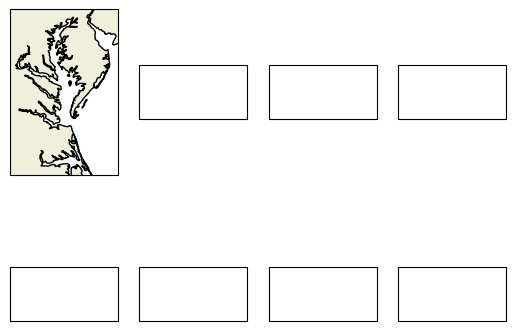

In [87]:
for month, ax in zip(months,axs.ravel()):
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    ax.set_extent([min(lon_range), max(lon_range),
               min(lat_range), max(lat_range)])

    sst_plot = ds_chesapeake.sel(time=month)["sst"]
    ax.pcolormesh(sst_plot, transform=ccrs.PlateCarree())
    break

In [81]:
axs.ravel()

array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
       <GeoAxes: >, <GeoAxes: >, <GeoAxes: >], dtype=object)

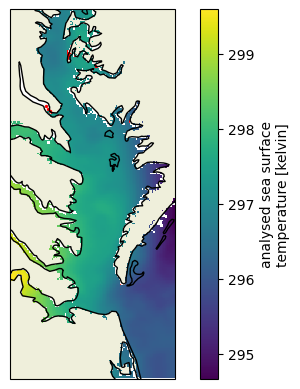

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
#ax.plot(lon_range,lat_range)
ax.scatter(red_drum_tag.longitude, red_drum_tag.latitude, s=2, color="red")

ax.set_extent([min(lon_range), max(lon_range),
               min(lat_range), max(lat_range)])

mean_ds['analysed_sst'].plot(x='lon', y='lat')

fig.savefig("first-week.png")

In [69]:
fileset[0]

<File-like object HTTPFileSystem, https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20240610090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc>

In [8]:
ds = xr.open_dataset(fileset[0])
ds

<xarray.Dataset> Size: 26GB
Dimensions:     (lat: 4320, lon: 8640, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 26GB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240609_20240616.L3m.8D.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         12044174
    data_minimum:                      -0.009998
    data_maximum:                      0.08155801

In [17]:
red_drum_tag.week_utc-pd.Timedelta(1, "D")

0     2024-06-09
1     2024-06-16
2     2024-06-23
3     2024-06-30
4     2024-07-07
         ...    
118   2024-10-13
119   2024-10-20
120   2024-10-27
121   2024-11-03
122   2024-11-10
Name: week_utc, Length: 123, dtype: datetime64[ns]

In [20]:
red_drum_tag.loc[red_drum_tag.week_utc-pd.Timedelta(1, "D")=="2024-06-09", "longitude"]

0   -76.336701
Name: longitude, dtype: float64

In [33]:
ds

<xarray.Dataset> Size: 26GB
Dimensions:     (lat: 4320, lon: 8640, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 26GB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240609_20240616.L3m.8D.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         12044174
    data_minimum:                      -0.009998
    data_maximum:                      0.08155801

In [39]:
red_drum_tag.loc[red_drum_tag.week_utc=="2024-06-10","latitude"]

0    38.727936
Name: latitude, dtype: float64

In [38]:
red_drum_tag.week_utc

0     2024-06-10
1     2024-06-17
2     2024-06-24
3     2024-07-01
4     2024-07-08
         ...    
118   2024-10-14
119   2024-10-21
120   2024-10-28
121   2024-11-04
122   2024-11-11
Name: week_utc, Length: 123, dtype: datetime64[ns]

In [40]:
for i, (lat,lon) in enumerate(zip(red_drum_tag.loc[red_drum_tag.week_utc=="2024-06-10","latitude"],
                                  red_drum_tag.loc[red_drum_tag.week_utc=="2024-06-10", "longitude"])):
    print(i,lat,lon)
    break

0 38.72793625 -76.33670053


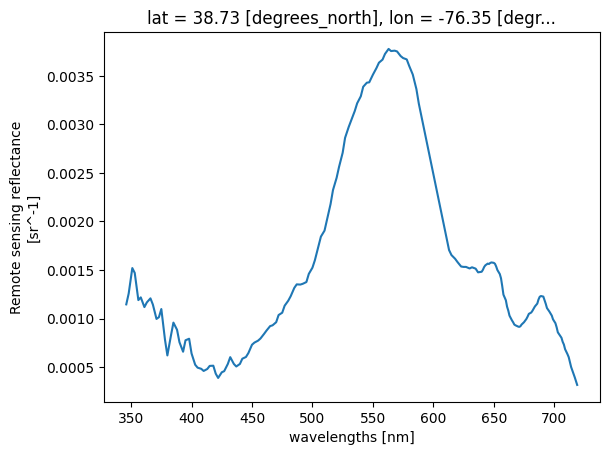

In [26]:
# Quick look at the water Reflectance 
pt = ds["Rrs"].sel(lat=red_drum_tag.loc[red_drum_tag.week_utc-pd.Timedelta(1, "D")=="2024-06-09", "latitude"][0],
                   lon=red_drum_tag.loc[red_drum_tag.week_utc-pd.Timedelta(1, "D")=="2024-06-09", "longitude"][0],
                   method="nearest")
pt.plot.line(x="wavelength")

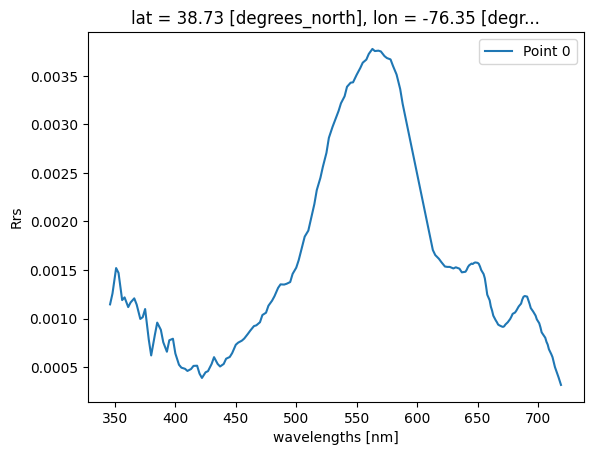

In [41]:
for i, (lat,lon) in enumerate(zip(red_drum_tag.loc[red_drum_tag.week_utc=="2024-06-10","latitude"],
                                  red_drum_tag.loc[red_drum_tag.week_utc=="2024-06-10", "longitude"])):
    pt = ds["Rrs"].sel(lat=lat, lon=lon, method="nearest")
    pt.plot.line(x="wavelength", label=f"Point {i}")   
plt.ylabel("Rrs")
plt.legend()
plt.show()

In [50]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ds_mid_atlantic = ds.sel(lat=slice(lat_range[1], lat_range[0]),
                         lon=slice(lon_range[0], lat_range[1]))

In [51]:
rrs = ds_mid_atlantic.sel(wavelength=443, method="nearest")

In [52]:
rrs

<xarray.Dataset> Size: 701kB
Dimensions:     (lat: 62, lon: 2779, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat         (lat) float32 248B 39.02 38.98 38.94 38.9 ... 36.56 36.52 36.48
  * lon         (lon) float32 11kB -76.73 -76.69 -76.65 ... 38.94 38.98 39.02
    wavelength  float64 8B 442.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon) float32 689kB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240609_20240616.L3m.8D.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         12044174
    data_minimum:                      -0.009998
    data_maximum:                      0.08155801

NameError: name 'track_df' is not defined

/home/tct/fish-pace/2026-proj-fishing-reddrum/.venv/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


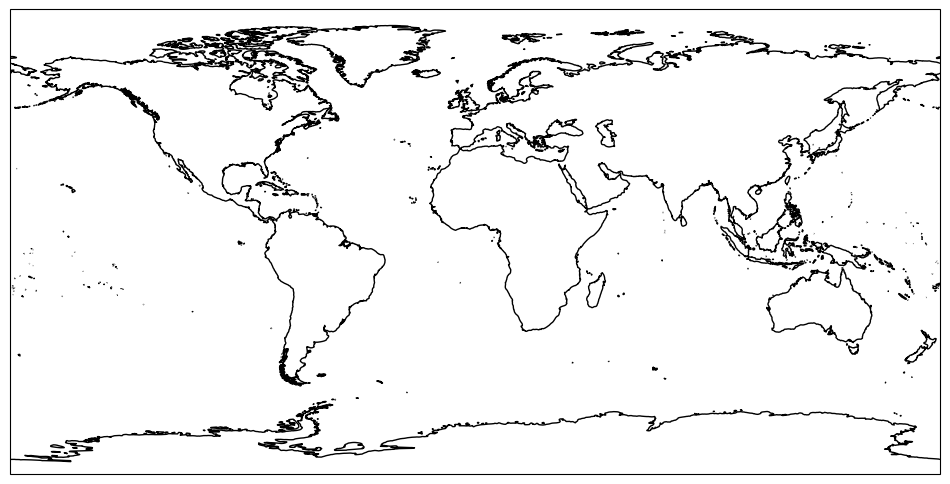

In [55]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"projection": ccrs.PlateCarree()})
#rrs.plot(ax=ax, cmap="jet", add_colorbar=True, vmin=0, vmax=0.02)
ax.coastlines(resolution="50m")
ax.scatter(fish, track_df["Latitude"], s=40, c="black", edgecolor="white", linewidth=0.5, label="Stations")
ax.legend(loc="upper right")